In [3]:
%cd "../"
%pwd

import numpy as np
import matplotlib.pyplot as plt

import io 
import pandas as pd  
import pyreadr

from load_data import *
from pred_score import *
from Filter_FS import *
from hybrid_FS import *
from overlap_genes import *
from crossValidation import *

/Users/dormann/Documents/GitHub/src


In [4]:
#Fixing seed to get reproducible results
random.seed(3)
np.random.seed(3)

# Baseline with preselected genes 

In [3]:
#Load preprocess data
DO = np.array(pd.read_csv ('../data/processed_data/D0.csv'))
y = np.array(DO[:,-1],dtype=int)
DO = DO[:,0:-1]

In [ ]:
#Predict and evaluate
model = FamiliesClusters(np.unique(y),compute_precision,True)
pred = model.fit_predict(DO,y)

In [ ]:
print(DO.shape, len(pred))
acc = model.score_
print(acc)

In [ ]:
print("TP, FP, ratio, sensitivity, specificity, precision, NPV, FDR, FNR = ", compute_statTP(y,pred))

# Mutual information maximizer (MIM)

In [ ]:
#Define parameters for MIM method
N = np.arange(80,3000,30)
kwargs = {'Model': FamiliesClusters, 'Scoring': compute_precision,'maximize': True,'N': N, 'n_neighbors': 4, 'plot': True} 

subset, score_training, score_testing = cross_validation(y,DO, FamiliesClusters, compute_precision,True, 10,  MIM, **kwargs)

mean_score_test, std_score_test = np.mean(score_testing), np.std(score_testing)    
print('test', mean_score_test, std_score_test)

#Predict and evaluate on whole data  set
model = FamiliesClusters(np.unique(y),compute_precision,True)
x_subset = DO[:, subset]
pred = model.fit_predict(x_subset,y)

print("TP, FP, ratio, sensitivity, specificity, precision, NPV, FDR, FNR = ", compute_statTP(y,pred))

# Anova F test

In [ ]:
#Define parameters for ANOVA method
N = np.arange(80,3000,30)
kwargs = {'Model': FamiliesClusters, 'Scoring': compute_precision,'maximize': True,'N': N, 'plot': True} 

subset, score_training, score_testing = cross_validation(y,DO, FamiliesClusters, compute_precision,True, 10,  ANOVA, **kwargs)

mean_score_test, std_score_test = np.mean(score_testing), np.std(score_testing)    
print('test', mean_score_test, std_score_test)

#Predict and evaluate on whole data  set
model = FamiliesClusters(np.unique(y),compute_precision,True)
x_subset = DO[:, subset]
pred = model.fit_predict(x_subset,y)

print("TP, FP, ratio, sensitivity, specificity, precision, NPV, FDR, FNR = ", compute_statTP(y,pred))    

# Without Cross-validation

### Experiments separately

D0_exp1

In [54]:
D0_df = pyreadr.read_r('../data/family_datasets/data_norm/BIDDY_D0_RPM_norm.rds')
D0_df = D0_df[None]

families_interest_D0 = pyreadr.read_r('../data/family_datasets/family_interest/families_of_interest_BIDDY_D0.RData')
families_interest_D0 = families_interest_D0['fois_1']

families_info_D0 = pyreadr.read_r('../data/family_datasets/family_info/family_info_BIDDY_D0.RData')
families_info_D0 = families_info_D0['family_info_1']

#Conversion into array 
families_interest_D0 = np.array(families_interest_D0)
families_info_D0 = np.array(families_info_D0) 

#Remove all genes that are not expressed in at least percentage (default 50%) of the cells
gene_expressed = filter_norm_data(D0_df,0.05)
D0_df = D0_df[gene_expressed]

#Store the name of genes of interest
genes_interest = D0_df.index.values #get name of genes
genes_interest = pd.DataFrame(genes_interest)
genes_interest.to_csv('../data/processed_data/D0_exp1genes_interest.csv', index=False)

#Norm data with only the cells belonging to the family of interest
D0_1 = select_family_interest_norm_data(families_info_D0, families_interest_D0, D0_df)
y = D0_1[1][:,0].astype(np.int32)
D0_1 = np.array(D0_1[0].T)

425 1.0


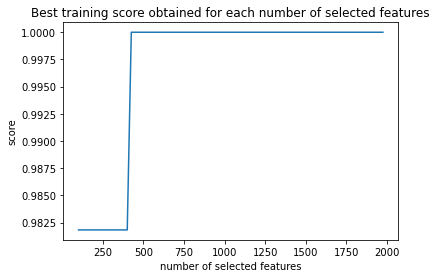

In [56]:
N = np.arange(100,2000,25)
best_subset, best_score = MIM(y, D0_1, FamiliesClusters, compute_precision,True, N, 3, plot=True) 
print(len(best_subset), best_score)

In [57]:
#Predict and evaluate on whole data  set
model = FamiliesClusters(np.unique(y),compute_precision,True)
x_subset = D0_1[:, best_subset]
pred = model.fit_predict(x_subset,y)
print(model.score_, model.recovery)

subset = np.ones((len(best_subset),))
subsets = subsampling_genes(subset, 101, 0.25)

model = EnsemblingHierarchical(np.unique(y),compute_precision,True,subsets = subsets, ensembling='voting', threshold_voting = 0.5)
result  = model.fit_predict(X = x_subset, y= y)
print(model.score_, model.recovery)

1.0 0.9821428571428571
1.0 0.9821428571428571


In [58]:
MIM_sub = best_subset

In [44]:
get_best_genes_names(MIM_sub, '../data/processed_data/D0_exp1genes_interest.csv', '../data/optimized_subsets/D0_exp1genes_best.csv')

/Users/dormann/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  400  6668  9839 10717 10719] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/Users/dormann/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


125 1.0


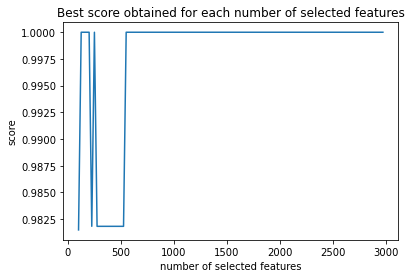

In [59]:
N = np.arange(100,3000,25)
best_subset, best_score = ANOVA(y, D0_1, FamiliesClusters, compute_precision,True, N, plot=True)
print(len(best_subset), best_score)

In [60]:
#Predict and evaluate on whole data  set
model = FamiliesClusters(np.unique(y),compute_precision,True)
x_subset = D0_1[:, best_subset]
pred = model.fit_predict(x_subset,y)
print(model.score_, model.recovery)

subset = np.ones((len(best_subset),))
subsets = subsampling_genes(subset, 101, 0.25)

model = EnsemblingHierarchical(np.unique(y),compute_precision,True,subsets = subsets, ensembling='voting', threshold_voting = 0.5)
result  = model.fit_predict(X = x_subset, y= y)
print(model.score_, model.recovery)

1.0 0.9821428571428571
1.0 0.9821428571428571


In [61]:
ANOVA_sub = best_subset

In [29]:
get_best_genes_names(ANOVA_sub, '../data/processed_data/D0_exp1genes_interest.csv', '../data/optimized_subsets/D0_exp1genes_best2.csv')

D0_exp2

In [47]:
D0_df = pyreadr.read_r('../data/family_datasets/data_norm/BIDDY_D0_2_RPM_norm.rds')
D0_df = D0_df[None]

families_interest_D0 = pyreadr.read_r('../data/family_datasets/family_interest/families_of_interest_BIDDY_D0_2.RData')
families_interest_D0 = families_interest_D0['fois_1']

families_info_D0 = pyreadr.read_r('../data/family_datasets/family_info/family_info_BIDDY_D0_2.RData')
families_info_D0 = families_info_D0['family_info_1']

#Conversion into array 
families_interest_D0 = np.array(families_interest_D0)
families_info_D0 = np.array(families_info_D0) 

families, count = np.unique(families_info_D0[:,0], return_counts=True)
family_interest_D0 = families[np.logical_and(count > 1, count < 6)]

#Remove all genes that are not expressed in at least percentage (default 50%) of the cells
gene_expressed = filter_norm_data(D0_df,0.05)
D0_df = D0_df[gene_expressed]

#Store the name of genes of interest
genes_interest = D0_df.index.values #get name of genes
genes_interest = pd.DataFrame(genes_interest)
genes_interest.to_csv('../data/processed_data/D0_exp2genes_interest.csv', index=False)

#Norm data with only the cells belonging to the family of interest
D0_2 = select_family_interest_norm_data(families_info_D0, families_interest_D0, D0_df)
y = D0_2[1][:,0].astype(np.int32)
D0_2 = np.array(D0_2[0].T)

225 0.9554140127388535


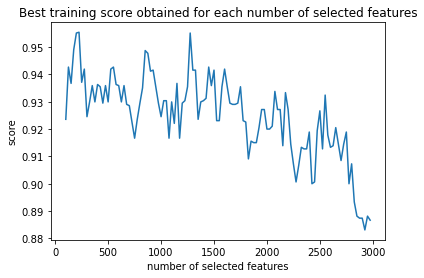

In [31]:
N = np.arange(100,3000,25)
best_subset, best_score = MIM(y, D0_2, FamiliesClusters, compute_precision,True, N, 3, plot=True) 
print(len(best_subset), best_score)

In [32]:
#Predict and evaluate on whole data  set
model = FamiliesClusters(np.unique(y),compute_precision,True)
x_subset = D0_2[:, best_subset]
pred = model.fit_predict(x_subset,y)
print(model.score_, model.recovery)

subset = np.ones((len(best_subset),))
subsets = subsampling_genes(subset, 101, 0.25)

model = EnsemblingHierarchical(np.unique(y),compute_precision,True,subsets = subsets, ensembling='voting', threshold_voting = 0.5)
result  = model.fit_predict(X = x_subset, y= y)
print(model.score_, model.recovery)

0.9554140127388535 0.8997134670487106
0.9865771812080537 0.8538681948424068


In [33]:
MIM_sub = best_subset

In [34]:
get_best_genes_names(MIM_sub, '../data/processed_data/D0_exp2genes_interest.csv', '../data/optimized_subsets/D0_exp2genes_best1.csv')

150 0.9683544303797469


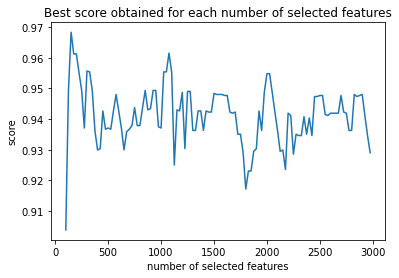

In [35]:
N = np.arange(100,3000,25)
best_subset, best_score = ANOVA(y, D0_2, FamiliesClusters, compute_precision,True, N, plot=True)
print(len(best_subset), best_score)

In [36]:
#Predict and evaluate on whole data  set
model = FamiliesClusters(np.unique(y),compute_precision,True)
x_subset = D0_2[:, best_subset]
pred = model.fit_predict(x_subset,y)
print(model.score_, model.recovery)

subset = np.ones((len(best_subset),))
subsets = subsampling_genes(subset, 101, 0.25)

model = EnsemblingHierarchical(np.unique(y),compute_precision,True,subsets = subsets, ensembling='voting', threshold_voting = 0.5)
result  = model.fit_predict(X = x_subset, y= y)
print(model.score_, model.recovery)

0.9683544303797469 0.9054441260744985
1.0 0.8424068767908309


157 0.9745222929936306


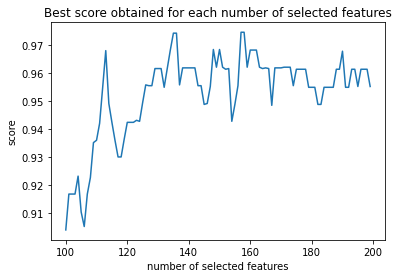

In [48]:
N = np.arange(100,200,1)
best_subset, best_score = ANOVA(y, D0_2, FamiliesClusters, compute_precision,True, N, plot=True)
print(len(best_subset), best_score)

In [50]:
#Predict and evaluate on whole data  set
model = FamiliesClusters(np.unique(y),compute_precision,True)
x_subset = D0_2[:, best_subset]
pred = model.fit_predict(x_subset,y)
print(model.score_, model.recovery)

subset = np.ones((len(best_subset),))
subsets = subsampling_genes(subset, 101, 0.25)

model = EnsemblingHierarchical(np.unique(y),compute_precision,True,subsets = subsets, ensembling='voting', threshold_voting = 0.5)
result  = model.fit_predict(X = x_subset, y= y)
print(model.score_, model.recovery)

0.9745222929936306 0.8997134670487106
0.9864864864864865 0.8481375358166189


In [51]:
ANOVA_sub = best_subset

In [52]:
get_best_genes_names(ANOVA_sub, '../data/processed_data/D0_exp2genes_interest.csv', '../data/optimized_subsets/D0_exp2genes_best.csv')